## Construction de la série temporelle
 Convertir le CSV en une série temporelle standard : `date -> pacific_area_km2`.

In [31]:
import numpy as np
import pandas as pd

XLSX_PATH = "south_sea_level.xlsx"
CSV_PATH  = "ocean_level_data.csv"

# 1) Charger fichiers
df_xlsx = pd.read_excel(XLSX_PATH)
df_csv  = pd.read_csv(CSV_PATH)

# 2) Récupérer les années (colonnes)
years_xlsx = sorted([c for c in df_xlsx.columns if isinstance(c, (int, np.integer))])
years_csv  = sorted([int(c) for c in df_csv.columns if str(c).isdigit()])

# 3) On utilise seulement l’intersection
common_years = sorted(set(years_xlsx).intersection(set(years_csv)))
assert len(common_years) > 0, "Aucune année commune entre XLSX et CSV."

# 4) Construire le calendrier (month/day) à partir du XLSX
cal = df_xlsx[["month", "day"]].copy()
cal["month"] = cal["month"].ffill()

month_map = {
    "January":1,"February":2,"March":3,"April":4,"May":5,"June":6,
    "July":7,"August":8,"September":9,"October":10,"November":11,"December":12
}
cal["month_num"] = cal["month"].map(month_map)
cal["day"] = cal["day"].astype(int)

# 5) Combiner calendrier + données CSV (années communes)
df_data = df_csv[[str(y) for y in common_years]].copy()
df_wide = pd.concat([cal[["month_num", "day"]], df_data], axis=1)

# 6) Wide -> long puis construction des dates
long = df_wide.melt(
    id_vars=["month_num", "day"],
    var_name="year",
    value_name="pacific_area_km2"
)
long["year"] = long["year"].astype(int)

long["date"] = pd.to_datetime(
    dict(year=long["year"], month=long["month_num"], day=long["day"]),
    errors="coerce"   # gère automatiquement les dates invalides (29/02 hors leap years)
)

# 7) Nettoyage minimal : on garde uniquement les points observés
long = long.dropna(subset=["date", "pacific_area_km2"]).sort_values("date").reset_index(drop=True)

# 8) Série finale
ts = long.set_index("date")["pacific_area_km2"].sort_index()

print("Built ts:")
print("  date_min:", ts.index.min())
print("  date_max:", ts.index.max())
print("  n_obs:", int(ts.notna().sum()))

Built ts:
  date_min: 1978-10-28 00:00:00
  date_max: 2026-01-12 00:00:00
  n_obs: 17205


## EDA 


## Data overview  et stats robustes

Objectif :
- Résumer proprement le dataset et ses défauts .
- Donner des statistiques robustes sur un segment continu sans valeurs manquantes.
- Quantifier la dynamique via les variations quotidiennes Δy (volatilité, extrêmes).

Méthode :
- On travaille sur `ts_daily` (grille journalière) pour détecter le gap.
- On définit `ts_eval` comme segment continu sans NaN : 1988-01-14 → 2025-12-31.

In [35]:
import numpy as np
import pandas as pd

# 1) Grille journalière
ts_daily = ts.asfreq("D")

# 2) Détection du plus grand gap (séquence NaN la plus longue)
is_missing = ts_daily.isna().astype(int)
segment_id = (is_missing.diff().fillna(0) != 0).cumsum()

missing_runs = ts_daily[ts_daily.isna()].groupby(segment_id).apply(
    lambda s: (s.index.min(), s.index.max(), len(s))
)

if len(missing_runs) > 0:
    gap_start, gap_end, gap_len = max(missing_runs.tolist(), key=lambda x: x[2])
else:
    gap_start, gap_end, gap_len = None, None, 0

# 3) Segment continu sans trous (pour stats propres)
EVAL_START = "1988-01-14"
EVAL_END   = "2025-12-31"
ts_eval = ts_daily.loc[EVAL_START:EVAL_END]

assert int(ts_eval.isna().sum()) == 0, "ts_eval doit être continu sans NaN."

# 4) Table factuelle dataset
overview = pd.DataFrame([{
    "date_min": ts.index.min().date(),
    "date_max": ts.index.max().date(),
    "n_obs": int(ts.notna().sum()),
    "n_missing_daily_grid": int(ts_daily.isna().sum()),
    "main_gap_start": None if gap_start is None else gap_start.date(),
    "main_gap_end": None if gap_end is None else gap_end.date(),
    "main_gap_length_days": int(gap_len),
    "eval_start": ts_eval.index.min().date(),
    "eval_end": ts_eval.index.max().date(),
    "eval_n_days": int(len(ts_eval))
}])
display(overview)

# 5) Stats robustes sur le niveau (ts_eval)
y = ts_eval.values.astype(float)

level_stats = pd.DataFrame([{
    "mean": float(np.mean(y)),
    "std": float(np.std(y)),
    "min": float(np.min(y)),
    "p01": float(np.quantile(y, 0.01)),
    "p05": float(np.quantile(y, 0.05)),
    "median": float(np.quantile(y, 0.50)),
    "p95": float(np.quantile(y, 0.95)),
    "p99": float(np.quantile(y, 0.99)),
    "max": float(np.max(y)),
    "IQR": float(np.quantile(y, 0.75) - np.quantile(y, 0.25)),
    "range": float(np.max(y) - np.min(y))
}])
display(level_stats)

# 6) Stats sur la dynamique : Δy = y_t - y_{t-1}
dy = ts_eval.diff().dropna().values.astype(float)

delta_stats = pd.DataFrame([{
    "mean_daily_change": float(np.mean(dy)),
    "std_daily_change": float(np.std(dy)),
    "p01": float(np.quantile(dy, 0.01)),
    "p05": float(np.quantile(dy, 0.05)),
    "median": float(np.quantile(dy, 0.50)),
    "p95": float(np.quantile(dy, 0.95)),
    "p99": float(np.quantile(dy, 0.99)),
    "min": float(np.min(dy)),
    "max": float(np.max(dy)),
}])
display(delta_stats)

# 7) Top événements extrêmes (Δy en valeur absolue)
dy_series = ts_eval.diff().dropna()
extreme = dy_series.abs().sort_values(ascending=False).head(10).to_frame("abs_daily_change")
extreme["signed_change"] = dy_series.loc[extreme.index].values
display(extreme)

,date_min,date_max,n_obs,n_missing_daily_grid,main_gap_start,main_gap_end,main_gap_length_days,eval_start,eval_end,eval_n_days
0,1978-10-28,2026-01-12,17205,39,1987-12-06,1988-01-13,39,1988-01-14,2025-12-31,13867


,mean,std,min,p01,p05,median,p95,p99,max,IQR,range
0,835744.273379,419173.502661,44064.349,135708.3607,221727.4452,847632.091,1.470765e+06,1.618209e+06,1806386.545,752950.5895,1762322.196


,mean_daily_change,std_daily_change,p01,p05,median,p95,p99,min,max
0,9.395539,14700.948711,-36230.6951,-24150.0755,-1021.7685,25004.57475,37564.80445,-68955.028,80615.601


,abs_daily_change,signed_change
date,,
1997-08-15,80615.601,80615.601
1997-08-14,71454.008,71454.008
2021-09-17,68955.028,-68955.028
1997-08-16,66343.514,66343.514
1999-10-17,64861.761,-64861.761
1998-08-05,64213.594,-64213.594
2021-09-16,63418.404,-63418.404
1999-10-16,61341.251,-61341.251
1998-08-06,59434.590,-59434.590


## Interprétation 
#### Qualité des données et couverture temporelle
- La série observée couvre la période **1978-10-28 → 2026-01-12** avec **17205** observations (points non manquants).
- Sur une grille journalière complète (`ts_daily`), il n’y a que **39 jours manquants**, et ils sont **tous concentrés dans un seul gap interne** :
  **1987-12-06 → 1988-01-13** (longueur = 39 jours).
- On définit un segment continu sans trous (`ts_eval`) : **1988-01-14 → 2025-12-31** (longueur = **13867 jours**).  
  Ce segment sert de référence pour produire des statistiques propres (non biaisées par des trous internes).

#### Échelle et variabilité du niveau (superficie en km²)
- Le niveau médian est d’environ 8.48×10⁵ km².
- La série présente une variabilité très forte :
  - écart-type ≈ 4.19×10⁵ km²
  - intervalle interquartile (IQR) ≈ 7.53×10⁵ km²
  - étendue (max − min) ≈ 1.76×10⁶ km²
- Les quantiles extrêmes sont très éloignés :
  - p01 ≈ 1.36×10⁵, p99 ≈ 1.62×10⁶, max ≈ 1.81×10⁶
  Cela indique que la distribution du niveau occupe une large plage de valeurs (cohérent avec une saisonnalité potentiellement dominante + variabilité interannuelle).

#### Dynamique court-terme : variations quotidiennes Δy
On étudie les incréments quotidiens \(\Delta y_t = y_t - y_{t-1}\) sur `ts_eval`.

- La dispersion des variations quotidiennes est modérée par rapport à l’échelle du niveau :
  - std(\(\Delta y\)) ≈ 1.47×10⁴ km²
- Les variations extrêmes existent (queues / événements ponctuels) :
  - min ≈ −68955 km², max ≈ +80616 km²
  - p01 ≈ −36231, p99 ≈ +37565
- La médiane de \(\Delta y\) est légèrement négative (≈ −1022 km²/jour) tandis que la moyenne est proche de 0 (≈ +9 km²/jour).  
  Cela suggère une dynamique globalement centrée mais possiblement asymétrique, et/ou influencée par la structure saisonnière.

#### Jours “extrêmes” (outliers en |Δy|)
Les plus fortes variations (en valeur absolue) sont concentrées sur quelques dates spécifiques :
- pics positifs autour de 1997-08-14/15/16
- pics négatifs autour de 2021-09-16/17, 1998-08-05/06, 1999-10-16/17, etc.

## Saison (cycle annuel moyen) + stabilité

On estime le cycle annuel moyen s(doy) sur le segment continu `ts_eval` :
- On retire le 29 février pour travailler sur 365 jours (cycle stable).
- On calcule :
  - amplitude = max(s) - min(s)
  - jour du minimum / maximum (phase)
  - fraction de variance expliquée par la saison : Var(s(doy)) / Var(y)

On mesure aussi la stabilité :
- Pour chaque année, on calcule la corrélation entre son profil moyen (par doy) et le cycle moyen global.
- Si les corrélations sont proches de 1, la saisonnalité est stable (même forme chaque année).


,season_amp_max_minus_min,doy365_of_min,doy365_of_max,season_variance_ratio_Var(s)/Var(y),residual_std_after_removing_season
0,1.130454e+06,60,250,0.908294,126889.283267


Years used for stability: 37 out of 38


,corr_min,corr_median,corr_p10,corr_p90,amp_year_median,amp_year_p10,amp_year_p90
0,0.904764,0.978832,0.956228,0.985797,1338981.074,1.097028e+06,1.515666e+06


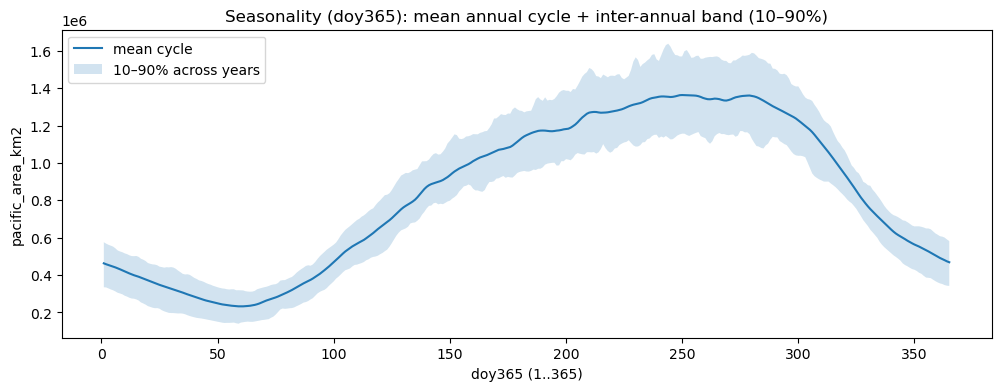

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Base
df = ts_eval.to_frame("y").copy()
df["year"] = df.index.year
df["month"] = df.index.month
df["day"]   = df.index.day

#Retirer le 29 février
df = df[~((df["month"] == 2) & (df["day"] == 29))].copy()

#Construire un doy365 invariant (month/day -> 1..365) via une année NON bissextile (2001)
ref = pd.date_range("2001-01-01", "2001-12-31", freq="D")  
ref_map = {(d.month, d.day): i+1 for i, d in enumerate(ref)}  
df["doy365"] = [ref_map[(m, d)] for m, d in zip(df["month"], df["day"])]

# --- Cycle moyen s(doy365)
cycle = df.groupby("doy365")["y"].mean().sort_index()

s = cycle.values
amp = float(s.max() - s.min())
doy_min = int(cycle.idxmin())
doy_max = int(cycle.idxmax())

y = df["y"].values.astype(float)
s_at_t = df["doy365"].map(cycle).values.astype(float)
resid = y - s_at_t

season_var_ratio = float(np.var(s_at_t) / np.var(y))

season_summary2 = pd.DataFrame([{
    "season_amp_max_minus_min": amp,
    "doy365_of_min": doy_min,
    "doy365_of_max": doy_max,
    "season_variance_ratio_Var(s)/Var(y)": season_var_ratio,
    "residual_std_after_removing_season": float(np.std(resid))
}])
display(season_summary2)

# Stabilité inter-années : profil annuel (moyenne par doy365) vs cycle global
per_year_corr = []
per_year_amp = []

for yr, g in df.groupby("year"):
    prof = g.groupby("doy365")["y"].mean().reindex(cycle.index)
    if prof.isna().any():
        continue
    per_year_corr.append((int(yr), float(np.corrcoef(prof.values, cycle.values)[0,1])))
    per_year_amp.append((int(yr), float(prof.max() - prof.min())))

per_year_corr = pd.DataFrame(per_year_corr, columns=["year", "corr_with_global_cycle"]).sort_values("year")
per_year_amp  = pd.DataFrame(per_year_amp, columns=["year", "amp_in_year"]).sort_values("year")

print("Years used for stability:", len(per_year_corr), "out of", df["year"].nunique())

stability_summary2 = pd.DataFrame([{
    "corr_min": float(per_year_corr["corr_with_global_cycle"].min()),
    "corr_median": float(per_year_corr["corr_with_global_cycle"].median()),
    "corr_p10": float(per_year_corr["corr_with_global_cycle"].quantile(0.10)),
    "corr_p90": float(per_year_corr["corr_with_global_cycle"].quantile(0.90)),
    "amp_year_median": float(per_year_amp["amp_in_year"].median()),
    "amp_year_p10": float(per_year_amp["amp_in_year"].quantile(0.10)),
    "amp_year_p90": float(per_year_amp["amp_in_year"].quantile(0.90)),
}])
display(stability_summary2)

#  bande 10–90% inter-années
q = df.groupby(["doy365", "year"])["y"].mean().reset_index()
band = q.groupby("doy365")["y"].quantile([0.10, 0.90]).unstack()

plt.figure(figsize=(12,4))
plt.plot(cycle.index, cycle.values, label="mean cycle")
plt.fill_between(band.index, band[0.10].values, band[0.90].values, alpha=0.2, label="10–90% across years")
plt.title("Seasonality (doy365): mean annual cycle + inter-annual band (10–90%)")
plt.xlabel("doy365 (1..365)")
plt.ylabel("pacific_area_km2")
plt.legend()
plt.show()


La série est dominée par une saisonnalité annuelle très forte : le cycle moyen a une amplitude d’environ **1.13×10⁶ km²** et explique **~91%** de la variance totale. Autrement dit, la majeure partie de la variabilité observée est “déterministe” à l’échelle de l’année. Une fois ce cycle retiré, la dispersion du résidu chute fortement (écart-type ≈ **1.27×10⁵ km²**), ce qui confirme que le signal brut est essentiellement un niveau saisonnier + une composante résiduelle beaucoup plus faible.

La phase est claire : le minimum saisonnier apparaît autour du **jour 60** (début mars) et le maximum autour du **jour 250** (début septembre), ce qui correspond à une montée prolongée au printemps/été puis une chute plus rapide vers l’hiver.

La forme du cycle est globalement stable d’une année à l’autre : sur **37 années** exploitables, la corrélation entre le profil annuel et le cycle moyen est typiquement très élevée (médiane ≈ **0.98**, et même la pire année reste > **0.90**). En revanche, l’amplitude varie entre années (ordre de grandeur ~**1.10×10⁶** à **1.52×10⁶** km² sur l’intervalle 10–90%), ce qui suggère que l’inter-annualité s’exprime surtout via un **changement d’amplitude et/ou de niveau**, plus que par une modification profonde de la forme saisonnière.


## Trend / variabilité interannuelle après retrait de la saison

Comme la saisonnalité explique ~91% de la variance, on analyse maintenant la composante lente.
On retire le cycle annuel moyen s(doy365), puis on étudie l’anomalie :
\[
a_t = y_t - s(doy365_t).
\]

Objectifs :
1) Quantifier la variabilité interannuelle : moyenne annuelle de a_t + incertitude.
2) Vérifier l’existence d’une tendance (régression linéaire de la moyenne annuelle).
3) Tester si une rupture de moyenne (un seul point de changement) est plausible via une comparaison SSE.


,alpha_intercept,beta_slope_per_year,R2_on_annual_means
0,-141330.892602,70.422622,0.000106


,best_break_year,SSE_no_break,SSE_best_1break,relative_SSE_reduction
0,2020,2.130566e+11,1.911813e+11,0.102674


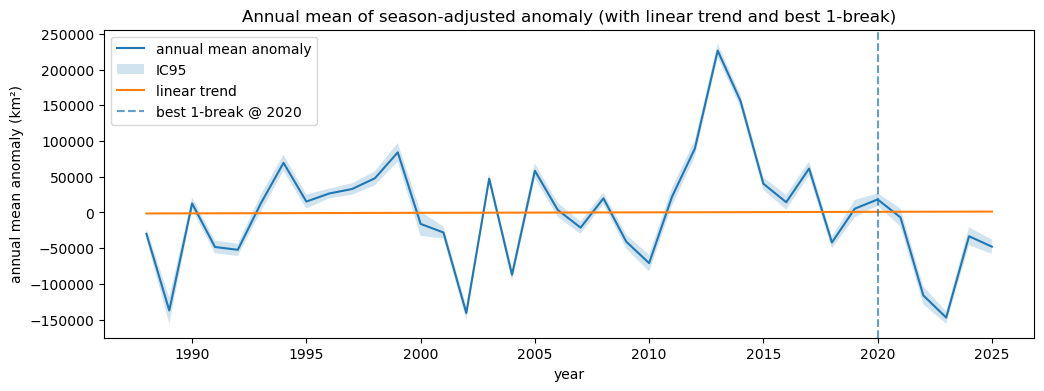

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Recréer df avec doy365 + cycle moyen
df = ts_eval.to_frame("y").copy()
df["year"] = df.index.year
df["month"] = df.index.month
df["day"]   = df.index.day

# retirer 29/02
df = df[~((df["month"] == 2) & (df["day"] == 29))].copy()

# doy365 invariant
ref = pd.date_range("2001-01-01", "2001-12-31", freq="D")
ref_map = {(d.month, d.day): i+1 for i, d in enumerate(ref)}
df["doy365"] = [ref_map[(m, d)] for m, d in zip(df["month"], df["day"])]

cycle = df.groupby("doy365")["y"].mean().sort_index()

#Anomalie saisonnièrement ajustée
df["season"] = df["doy365"].map(cycle).astype(float)
df["anom"] = df["y"] - df["season"]

#Moyenne annuelle de l’anomalie (variabilité interannuelle)
yearly = df.groupby("year")["anom"].agg(["mean", "std", "count"]).reset_index()
yearly["se"] = yearly["std"] / np.sqrt(yearly["count"])
yearly["ci95"] = 1.96 * yearly["se"]

#Tendance linéaire sur la moyenne annuelle
# modèle: mean_year = alpha + beta * year
x = yearly["year"].values.astype(float)
y = yearly["mean"].values.astype(float)

X = np.column_stack([np.ones_like(x), x])
beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]  # [alpha, beta]
y_fit = X @ beta_hat

# R^2 sur la moyenne annuelle (tendance "expliquée")
ss_res = float(np.sum((y - y_fit)**2))
ss_tot = float(np.sum((y - y.mean())**2))
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

trend_summary = pd.DataFrame([{
    "alpha_intercept": float(beta_hat[0]),
    "beta_slope_per_year": float(beta_hat[1]),
    "R2_on_annual_means": float(r2)
}])
display(trend_summary)

# Test  de rupture (1 break) sur moyenne annuelle
# On cherche un break year k qui minimise SSE gauche + SSE droite
# (exclure les bords pour éviter surfit)
years = yearly["year"].values.astype(int)
means = yearly["mean"].values.astype(float)

def sse_segment(xx, yy):
    # fit intercept only (mean) sur segment => SSE = sum (yy - mean)^2
    m = yy.mean()
    return float(np.sum((yy - m)**2))

best = {"break_year": None, "sse_left": None, "sse_right": None, "sse_total": np.inf}
for i in range(5, len(years)-5):
    left = means[:i]
    right = means[i:]
    sse = sse_segment(years[:i], left) + sse_segment(years[i:], right)
    if sse < best["sse_total"]:
        best = {
            "break_year": int(years[i]),
            "sse_left": float(sse_segment(years[:i], left)),
            "sse_right": float(sse_segment(years[i:], right)),
            "sse_total": float(sse)
        }

# comparaison avec modèle sans rupture (mean global)
sse_nobreak = float(np.sum((means - means.mean())**2))
break_gain = 1.0 - best["sse_total"]/sse_nobreak if sse_nobreak > 0 else np.nan

break_summary = pd.DataFrame([{
    "best_break_year": best["break_year"],
    "SSE_no_break": sse_nobreak,
    "SSE_best_1break": best["sse_total"],
    "relative_SSE_reduction": break_gain
}])
display(break_summary)

#fig moyenne annuelle anomalie + trend + (option) break
plt.figure(figsize=(12,4))
plt.plot(yearly["year"], yearly["mean"], label="annual mean anomaly")
plt.fill_between(yearly["year"], yearly["mean"]-yearly["ci95"], yearly["mean"]+yearly["ci95"], alpha=0.2, label="IC95")
plt.plot(yearly["year"], y_fit, label="linear trend")

if best["break_year"] is not None:
    plt.axvline(best["break_year"], linestyle="--", alpha=0.7, label=f"best 1-break @ {best['break_year']}")

plt.title("Annual mean of season-adjusted anomaly (with linear trend and best 1-break)")
plt.xlabel("year")
plt.ylabel("annual mean anomaly (km²)")
plt.legend()
plt.show()

Une fois la saisonnalité retirée, la moyenne annuelle de l’anomalie ne montre pratiquement **aucune tendance linéaire** : la pente estimée est proche de zéro à l’échelle de la variabilité interannuelle, et le R² est quasi nul. Autrement dit, la composante lente résiduelle n’est pas bien décrite par une simple tendance monotone.

En revanche, un modèle avec une rupture unique de moyenne améliore légèrement l’ajustement (réduction relative de SSE d’environ 10%), avec une rupture située vers 2020. C’est un signal faible à modéré : cela suggère une possible différence “avant/après”, mais ce n’est pas une preuve forte d’un changement structurel. Pour rester rigoureux, on garde ce résultat comme un indicateur exploratoire, et on évite d’en déduire une causalité.


## Dépendance temporelle et mémoire longue (long memory)

But :
- Tester si, après retrait de la saisonnalité (et d’une tendance éventuelle), le résidu présente une dépendance persistante à long terme.
- On travaille sur une série la plus stationnaire possible, car les estimateurs de mémoire longue supposent stationnarité.

Méthode :
1) Construire le résidu r_t = y_t - s(doy365_t).
2) retirer une petite tendance linéaire sur r_t si nécessaire.
3) Diagnostiquer la dépendance :
   - ACF sur de grands lags (la mémoire longue implique une décroissance lente)
   - estimateur GPH de d (semi-paramétrique, basé sur les basses fréquences)
   - robustesse à m (bandwidth)
   - test par permutation de blocs (p-value) : est-ce que d_observé est “vraiment” grand ?


Detrending slope on daily residual: 0.18156315978258325


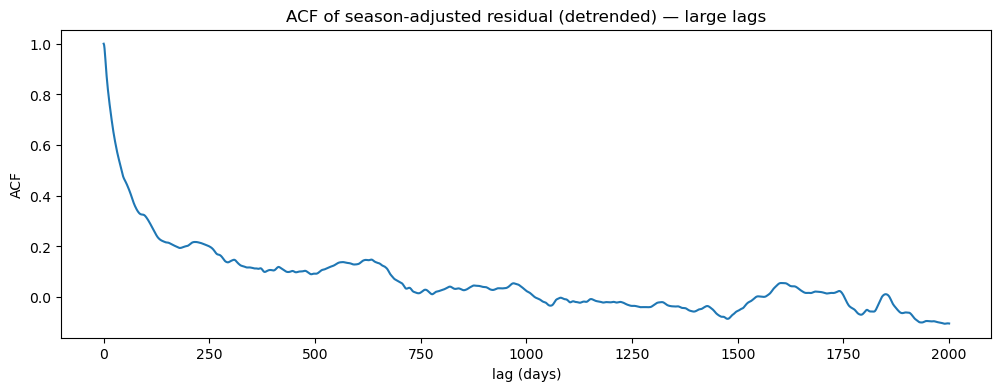

,m,d_hat,se,z=d/se
0,45,0.408977,0.133376,3.066352
1,117,0.443973,0.068864,6.447063
2,305,0.557354,0.040530,13.751716


,m_used,block_size,n_perm,d_obs,p_value_one_sided,perm_d_mean,perm_d_p95
0,117,30,200,0.443973,0.004975,0.02996,0.118761


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft

#=Construire r_t = y - saison (doy365)
df = ts_eval.to_frame("y").copy()
df["year"] = df.index.year
df["month"] = df.index.month
df["day"]   = df.index.day

# retirer 29/02
df = df[~((df["month"] == 2) & (df["day"] == 29))].copy()

# doy365 invariant (month/day -> 1..365)
ref = pd.date_range("2001-01-01", "2001-12-31", freq="D")
ref_map = {(d.month, d.day): i+1 for i, d in enumerate(ref)}
df["doy365"] = [ref_map[(m, d)] for m, d in zip(df["month"], df["day"])]

cycle = df.groupby("doy365")["y"].mean().sort_index()
df["season"] = df["doy365"].map(cycle).astype(float)

# résidu saisonnier
r = (df["y"] - df["season"]).astype(float).values
r = r - r.mean()  # centrage

# retirer tendance linéaire sur r_t 
t = np.arange(len(r), dtype=float)
coef = np.polyfit(t, r, 1)
trend_r = coef[0]*t + coef[1]
r_detr = r - trend_r

print("Detrending slope on daily residual:", float(coef[0]))

#ACF sur grands lags
def acf_fast(x, max_lag):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    # autocorr via FFT
    f = fft(x, n=2*n)
    acov = np.fft.ifft(f * np.conjugate(f)).real[:max_lag+1] / n
    return acov / acov[0]

MAX_LAG = 2000
acf_vals = acf_fast(r_detr, MAX_LAG)

plt.figure(figsize=(12,4))
plt.plot(np.arange(MAX_LAG+1), acf_vals)
plt.title("ACF of season-adjusted residual (detrended) — large lags")
plt.xlabel("lag (days)")
plt.ylabel("ACF")
plt.show()

#GPH estimator (semi-parametric) 
def gph_estimator(x, m=None):
    """
    Geweke–Porter–Hudak estimator of d using log-periodogram regression.
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    x = x - x.mean()
    T = len(x)

    if m is None:
        m = int(np.floor(np.sqrt(T)))
    m = max(20, min(m, T//2 - 1))

    j = np.arange(1, m+1)
    lam = 2*np.pi*j / T

    X = fft(x)
    I = (1/(2*np.pi*T)) * (np.abs(X[j])**2)

    y = np.log(I)
    z = -2*np.log(2*np.sin(lam/2))

    Z = np.column_stack([np.ones_like(z), z])
    beta = np.linalg.lstsq(Z, y, rcond=None)[0]
    resid = y - Z @ beta
    s2 = np.sum(resid**2) / (len(y) - 2)
    cov = s2 * np.linalg.inv(Z.T @ Z)

    d_hat = float(beta[1])
    se_d  = float(np.sqrt(cov[1,1]))
    return d_hat, se_d

T = len(r_detr)
m_list = [int(T**0.4), int(T**0.5), int(T**0.6)]
rows = []
for m in m_list:
    d_hat, se = gph_estimator(r_detr, m=m)
    rows.append({"m": m, "d_hat": d_hat, "se": se, "z=d/se": d_hat/se if se>0 else np.nan})
gph_table = pd.DataFrame(rows)
display(gph_table)

# Test permutation par blocs (p-value) 
# Hypothèse : on casse la dépendance long-range en permutant des blocs (on conserve la texture locale).
rng = np.random.default_rng(0)

def block_permutation(x, block_size, rng):
    x = np.asarray(x)
    n = len(x)
    nb = int(np.ceil(n / block_size))
    blocks = [x[i*block_size : min((i+1)*block_size, n)] for i in range(nb)]
    perm = rng.permutation(nb)
    return np.concatenate([blocks[i] for i in perm])

def permutation_test_d(x, m, block_size=30, n_perm=200):
    d_obs, _ = gph_estimator(x, m=m)
    ds = []
    for _ in range(n_perm):
        xp = block_permutation(x, block_size, rng)
        d_p, _ = gph_estimator(xp, m=m)
        ds.append(d_p)
    ds = np.array(ds)
    p = (np.sum(ds >= d_obs) + 1) / (len(ds) + 1)  # one-sided: d large
    return d_obs, ds, p

m0 = int(T**0.5)
d_obs, d_perm, pval = permutation_test_d(r_detr, m=m0, block_size=30, n_perm=200)

perm_summary = pd.DataFrame([{
    "m_used": m0,
    "block_size": 30,
    "n_perm": 200,
    "d_obs": float(d_obs),
    "p_value_one_sided": float(pval),
    "perm_d_mean": float(d_perm.mean()),
    "perm_d_p95": float(np.quantile(d_perm, 0.95))
}])
display(perm_summary)

Après retrait de la saison (et d’une tendance linéaire très faible sur le résidu), l’ACF décroît lentement et reste nettement positive sur des centaines de jours, puis ne devient proche de zéro que très progressivement. Ce type de décroissance “lente” est précisément ce qu’on attend d’une dépendance à longue portée (long-range dependence), par opposition à une mémoire courte (ARMA) où l’ACF chute beaucoup plus vite.

L’estimateur GPH donne un paramètre de mémoire longue d’environ **d ≈ 0.41–0.44** pour des bandes passantes modestes, et il augmente jusqu’à **d ≈ 0.56** quand on prend une bande beaucoup plus large. Le fait que d varie avec m indique une sensibilité au choix de bande  et suggère qu’il peut rester un peu de structure très basse fréquence (changement de régime, non-stationnarité résiduelle) qui pousse l’estimation vers le haut quand m est grand. on a donc une **forte évidence de mémoire longue**, avec une valeur “robuste” autour de **d ≈ 0.44**.

Le test par permutation de blocs confirme que ce d observé n’est pas expliqué par une dépendance locale de court terme : sous le null (blocs permutés), d est typiquement petit (moyenne ≈ 0.03, 95% ≈ 0.12), alors que d_obs ≈ 0.44, avec une p-value ≈ 0.005. Cela apporte une preuve empirique forte d’une dépendance persistante à long terme dans le résidu saisonnier.
